In [1]:
from gurobipy import *
import math
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd
import re
from random import randrange

We create the graph with its nodes, edges, and attributes

This are the node locations for the selected topology:
[(0, 'N1'), (1, 'N2'), (2, 'N3'), (3, 'N4'), (4, 'N5'), (5, 'N6'), (6, 'N7'), (7, 'N8'), (8, 'N9'), (9, 'N10'), (10, 'N11'), (11, 'N12'), (12, 'N13'), (13, 'N14'), (14, 'N15')]
\
This are the existing links for the selected topology:
[(0, 7, None), (0, 6, None), (0, 5, None), (1, 2, None), (1, 4, None), (1, 5, None), (2, 7, None), (2, 4, None), (3, 5, None), (3, 4, None), (5, 12, None), (6, 9, None), (6, 13, None), (7, 8, None), (7, 14, None), (8, 14, None), (8, 9, None), (8, 11, None), (9, 11, None), (10, 13, None), (10, 12, None), (12, 13, None)]


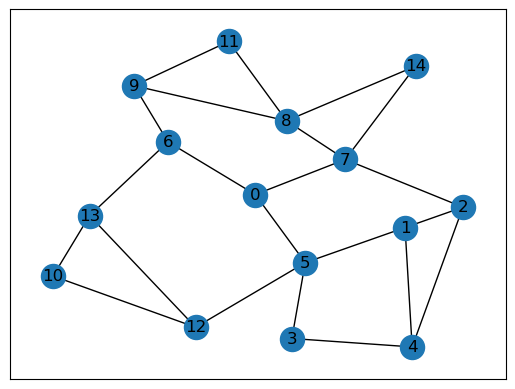

In [2]:
#to select US-Canada graph, write './us-ca.gml', for EU graph './eu.gml', and for Atlanta graph './atlanta.gml'
V=nx.read_gml('./atlanta.gml',destringizer=int)
N=5
print('This are the node locations for the selected topology:')
print(V.nodes(data='name'))
print('\\')
print('This are the existing links for the selected topology:')
print(V.edges(data='name'))
node_positions = {}

for node, attributes in V.nodes(data=True):
    
    graphics = attributes.get('graphics', {})
    x = graphics.get('x', 0)
    y = graphics.get('y', 0)
    
    node_positions[node] = (x, y)
nx.draw_networkx(V, pos=node_positions, with_labels=True)


In [3]:
#We arbitrarly select DCNs
'''DCN_sel=[]
i=0
while i<N:
    tmp=randrange(V.number_of_nodes())
    if tmp not in DCN_sel:
        DCN_sel.append(tmp)
        i=i+1
print(DCN_sel)
'''







'DCN_sel=[]\ni=0\nwhile i<N:\n    tmp=randrange(V.number_of_nodes())\n    if tmp not in DCN_sel:\n        DCN_sel.append(tmp)\n        i=i+1\nprint(DCN_sel)\n'

In [4]:
DCN_sel=[10, 14, 3, 13, 1]
print("Nodes Selected to be DCNs")
for i in V.nodes():

    if i in DCN_sel:
        V.nodes[i]['S']=1
        print(i,V.nodes[i]["name"])
    else:
        V.nodes[i]['S']=0
print(V.nodes(data='S'))




Nodes Selected to be DCNs
1 N2
3 N4
10 N11
13 N14
14 N15
[(0, 0), (1, 1), (2, 0), (3, 1), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 1), (11, 0), (12, 0), (13, 1), (14, 1)]


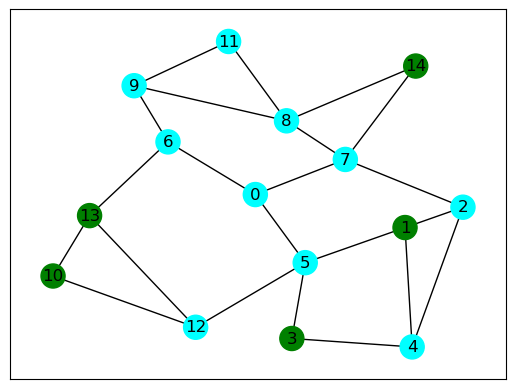

In [5]:
color_map=[]
for i in V.nodes():
    if V.nodes[i]['S']==1:
        color_map.append('green')
    else:
        color_map.append('cyan')
nx.draw_networkx(V, with_labels=True,node_color=color_map, pos=node_positions)

In [6]:
#nw_mod.reset(0) 
nw_mod=Model(name="nw")

C=100
c=10
T=50
t=30

delta_ij = nw_mod.addVars(V.number_of_nodes(),V.number_of_nodes(),name='delta_{i}_{j}',vtype=GRB.BINARY)
x=nw_mod.addVars(V.number_of_nodes(),name='x',vtype=GRB.BINARY)
y=nw_mod.addVars(V.number_of_nodes(),name='y',vtype=GRB.BINARY)
z=nw_mod.addVars(V.number_of_nodes(),name='z',vtype=GRB.BINARY)
u=nw_mod.addVars(V.number_of_nodes(),name='u',vtype=GRB.BINARY)
a=nw_mod.addVars(V.number_of_nodes(),name='a',vtype=GRB.BINARY)
b=nw_mod.addVars(V.number_of_nodes(),name='b',vtype=GRB.BINARY)
w=nw_mod.addVars(V.number_of_nodes(),name='w',vtype=GRB.BINARY)

obj_fun=sum(c*delta_ij[i,j] for i,j in V.edges())+sum(t*u[k] for k in V.nodes())
nw_mod.setObjective(obj_fun, GRB.MINIMIZE)

for i in V.nodes():
    nw_mod.addConstr(x[i] + y[i] + z[i] == 1, 'constraint_one_subd{i}')
    
for i in V.nodes():
    nw_mod.addConstr(2*a[i]<=u[i]+x[i],'constraint_ui_xi')
    nw_mod.addConstr(2*b[i]<=u[i]+y[i],'constraint_ui_yi')
    nw_mod.addConstr(2*w[i]<=u[i]+z[i],'constraint_ui_zi')

    nw_mod.addConstr(1+2*a[i]>=u[i]+x[i],'constraint_ui_xi_2')
    nw_mod.addConstr(1+2*b[i]>=u[i]+y[i],'constraint_ui_yi_2')
    nw_mod.addConstr(1+2*w[i]>=u[i]+z[i],'constraint_ui_zi_2')

#nw_mod.addConstr(sum(x[i] for i in V.nodes())>=sum(y[i] for i in V.nodes()),'constraint_max_x')
#nw_mod.addConstr(sum(y[i] for i in V.nodes())>=sum(z[i] for i in V.nodes()),'constraint_max_y')

#nw_mod.addConstr(sum(x[i] for i in V.nodes())>=sum(y[i] for i in V.nodes())+sum(z[i] for i in V.nodes()),'constraint_max_x')

nw_mod.addConstr(sum(V.nodes[i]['S'] * (x[i]-a[i]) for i in V.nodes()) <= (math.ceil(N/2)) - 1, 'constraint_sum_S_x')
nw_mod.addConstr(sum(V.nodes[i]['S'] * (y[i]-b[i]) for i in V.nodes()) <= (math.ceil(N/2)) - 1, 'constraint_sum_S_y')
nw_mod.addConstr(sum(V.nodes[i]['S'] * (z[i]-w[i]) for i in V.nodes()) <= (math.ceil(N/2)) - 1, 'constraint_sum_S_z')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-29


<gurobi.Constr *Awaiting Model Update*>

In [7]:

for i, j in V.edges():
    nw_mod.addConstr(delta_ij[i, j] <= 2 - x[i] - x[j], f'constraint_delta_ij_x_{i}_{j}_same_x')
    nw_mod.addConstr(delta_ij[j, i] <= 2 - x[i] - x[j], f'constraint_delta_ij_x_{i}_{j}_same_x_2')
    nw_mod.addConstr(delta_ij[i, j] <= 2 - y[i] - y[j], f'constraint_delta_ij_x_{i}_{j}_same_y')
    nw_mod.addConstr(delta_ij[j, i] <= 2 - y[i] - y[j], f'constraint_delta_ij_x_{i}_{j}_same_y_2')
    nw_mod.addConstr(delta_ij[i, j] <= 2 - z[i] - z[j], f'constraint_delta_ij_x_{i}_{j}_same_z')
    nw_mod.addConstr(delta_ij[j, i] <= 2 - z[i] - z[j], f'constraint_delta_ij_x_{i}_{j}_same_z_2')
    nw_mod.addConstr(delta_ij[i, j] >= x[i] - x[j], f'constraint_delta_ij_x_{i}_{j}_not_same_x')
    nw_mod.addConstr(delta_ij[i, j] >= x[j] - x[i], f'constraint_delta_ij_x_{i}_{j}_not_same_x_2')
    nw_mod.addConstr(delta_ij[i, j] >= y[i] - y[j], f'constraint_delta_ij_x_{i}_{j}_not_same_y')
    nw_mod.addConstr(delta_ij[i, j] >= y[j] - y[i], f'constraint_delta_ij_x_{i}_{j}_not_same_y_2')
    nw_mod.addConstr(delta_ij[i, j] >= z[i] - z[j], f'constraint_delta_ij_x_{i}_{j}_not_same_z')
    nw_mod.addConstr(delta_ij[i, j] >= z[j] - z[i], f'constraint_delta_ij_x_{i}_{j}_not_same_z_2')


In [8]:



#nw_mod.setParam('OutputFlag',False)
nw_mod.optimize()
#nw_mod.computeIIS()
print (nw_mod.display())
print('Optimization is done. Objective function value: %.2f' % nw_mod.objVal)
for v in nw_mod.getVars():
    print ('%s: %g' % (v.varName,v.x))

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 372 rows, 330 columns and 1137 nonzeros
Model fingerprint: 0x5f25e840
Variable types: 0 continuous, 330 integer (330 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+01, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 100.0000000
Presolve removed 126 rows and 243 columns
Presolve time: 0.00s
Presolved: 246 rows, 87 columns, 759 nonzeros
Variable types: 0 continuous, 87 integer (87 binary)

Root relaxation: objective 0.000000e+00, 43 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap 

  constraint_ui_zi_2: -1.0 z[12] + -1.0 u[12] + 2.0 w[12] >= -1
  constraint_ui_xi: -1.0 x[13] + -1.0 u[13] + 2.0 a[13] <= 0
  constraint_ui_yi: -1.0 y[13] + -1.0 u[13] + 2.0 b[13] <= 0
  constraint_ui_zi: -1.0 z[13] + -1.0 u[13] + 2.0 w[13] <= 0
  constraint_ui_xi_2: -1.0 x[13] + -1.0 u[13] + 2.0 a[13] >= -1
  constraint_ui_yi_2: -1.0 y[13] + -1.0 u[13] + 2.0 b[13] >= -1
  constraint_ui_zi_2: -1.0 z[13] + -1.0 u[13] + 2.0 w[13] >= -1
  constraint_ui_xi: -1.0 x[14] + -1.0 u[14] + 2.0 a[14] <= 0
  constraint_ui_yi: -1.0 y[14] + -1.0 u[14] + 2.0 b[14] <= 0
  constraint_ui_zi: -1.0 z[14] + -1.0 u[14] + 2.0 w[14] <= 0
  constraint_ui_xi_2: -1.0 x[14] + -1.0 u[14] + 2.0 a[14] >= -1
  constraint_ui_yi_2: -1.0 y[14] + -1.0 u[14] + 2.0 b[14] >= -1
  constraint_ui_zi_2: -1.0 z[14] + -1.0 u[14] + 2.0 w[14] >= -1
constraint_sum_S_x: x[1] + x[3] + x[10] + x[13] + x[14] + -1.0 a[1] + -1.0 a[3] + -1.0
 a[10] + -1.0 a[13] + -1.0 a[14] <= 2
constraint_sum_S_y: y[1] + y[3] + y[10] + y[13] + y[14] + -1.

C:\Users\rodri\AppData\Local\Temp\ipykernel_31412\2754967582.py:4: DeprecationWarning: Model.display() is deprecated
  print (nw_mod.display())


  constraint_delta_ij_x_0_6_same_y_2: delta_{i}_{j}[6,0] + y[0] + y[6] <= 2
  constraint_delta_ij_x_0_6_same_z: delta_{i}_{j}[0,6] + z[0] + z[6] <= 2
  constraint_delta_ij_x_0_6_same_z_2: delta_{i}_{j}[6,0] + z[0] + z[6] <= 2
  constraint_delta_ij_x_0_6_not_same_x: delta_{i}_{j}[0,6] + -1.0 x[0] + x[6] >= 0
  constraint_delta_ij_x_0_6_not_same_x_2: delta_{i}_{j}[0,6] + x[0] + -1.0 x[6] >= 0
  constraint_delta_ij_x_0_6_not_same_y: delta_{i}_{j}[0,6] + -1.0 y[0] + y[6] >= 0
  constraint_delta_ij_x_0_6_not_same_y_2: delta_{i}_{j}[0,6] + y[0] + -1.0 y[6] >= 0
  constraint_delta_ij_x_0_6_not_same_z: delta_{i}_{j}[0,6] + -1.0 z[0] + z[6] >= 0
  constraint_delta_ij_x_0_6_not_same_z_2: delta_{i}_{j}[0,6] + z[0] + -1.0 z[6] >= 0
  constraint_delta_ij_x_0_5_same_x: delta_{i}_{j}[0,5] + x[0] + x[5] <= 2
  constraint_delta_ij_x_0_5_same_x_2: delta_{i}_{j}[5,0] + x[0] + x[5] <= 2
  constraint_delta_ij_x_0_5_same_y: delta_{i}_{j}[0,5] + y[0] + y[5] <= 2
  constraint_delta_ij_x_0_5_same_y_2: delta_{i

  constraint_delta_ij_x_3_4_not_same_z: delta_{i}_{j}[3,4] + -1.0 z[3] + z[4] >= 0
  constraint_delta_ij_x_3_4_not_same_z_2: delta_{i}_{j}[3,4] + z[3] + -1.0 z[4] >= 0
  constraint_delta_ij_x_5_12_same_x: delta_{i}_{j}[5,12] + x[5] + x[12] <= 2
  constraint_delta_ij_x_5_12_same_x_2: delta_{i}_{j}[12,5] + x[5] + x[12] <= 2
  constraint_delta_ij_x_5_12_same_y: delta_{i}_{j}[5,12] + y[5] + y[12] <= 2
  constraint_delta_ij_x_5_12_same_y_2: delta_{i}_{j}[12,5] + y[5] + y[12] <= 2
  constraint_delta_ij_x_5_12_same_z: delta_{i}_{j}[5,12] + z[5] + z[12] <= 2
  constraint_delta_ij_x_5_12_same_z_2: delta_{i}_{j}[12,5] + z[5] + z[12] <= 2
  constraint_delta_ij_x_5_12_not_same_x: delta_{i}_{j}[5,12] + -1.0 x[5] + x[12] >= 0
  constraint_delta_ij_x_5_12_not_same_x_2: delta_{i}_{j}[5,12] + x[5] + -1.0 x[12] >= 0
  constraint_delta_ij_x_5_12_not_same_y: delta_{i}_{j}[5,12] + -1.0 y[5] + y[12] >= 0
  constraint_delta_ij_x_5_12_not_same_y_2: delta_{i}_{j}[5,12] + y[5] + -1.0 y[12] >= 0
  constraint_del

  constraint_delta_ij_x_9_11_same_y_2: delta_{i}_{j}[11,9] + y[9] + y[11] <= 2
  constraint_delta_ij_x_9_11_same_z: delta_{i}_{j}[9,11] + z[9] + z[11] <= 2
  constraint_delta_ij_x_9_11_same_z_2: delta_{i}_{j}[11,9] + z[9] + z[11] <= 2
  constraint_delta_ij_x_9_11_not_same_x: delta_{i}_{j}[9,11] + -1.0 x[9] + x[11] >= 0
  constraint_delta_ij_x_9_11_not_same_x_2: delta_{i}_{j}[9,11] + x[9] + -1.0 x[11] >= 0
  constraint_delta_ij_x_9_11_not_same_y: delta_{i}_{j}[9,11] + -1.0 y[9] + y[11] >= 0
  constraint_delta_ij_x_9_11_not_same_y_2: delta_{i}_{j}[9,11] + y[9] + -1.0 y[11] >= 0
  constraint_delta_ij_x_9_11_not_same_z: delta_{i}_{j}[9,11] + -1.0 z[9] + z[11] >= 0
  constraint_delta_ij_x_9_11_not_same_z_2: delta_{i}_{j}[9,11] + z[9] + -1.0 z[11] >= 0
  constraint_delta_ij_x_10_13_same_x: delta_{i}_{j}[10,13] + x[10] + x[13] <= 2
  constraint_delta_ij_x_10_13_same_x_2: delta_{i}_{j}[13,10] + x[10] + x[13] <= 2
  constraint_delta_ij_x_10_13_same_y: delta_{i}_{j}[10,13] + y[10] + y[13] <= 2
 

'delta_{i}_{j}[12,14]', 'delta_{i}_{j}[13,0]', 'delta_{i}_{j}[13,1]',
'delta_{i}_{j}[13,2]', 'delta_{i}_{j}[13,3]', 'delta_{i}_{j}[13,4]',
'delta_{i}_{j}[13,5]', 'delta_{i}_{j}[13,6]', 'delta_{i}_{j}[13,7]',
'delta_{i}_{j}[13,8]', 'delta_{i}_{j}[13,9]', 'delta_{i}_{j}[13,10]',
'delta_{i}_{j}[13,11]', 'delta_{i}_{j}[13,12]', 'delta_{i}_{j}[13,13]',
'delta_{i}_{j}[13,14]', 'delta_{i}_{j}[14,0]', 'delta_{i}_{j}[14,1]',
'delta_{i}_{j}[14,2]', 'delta_{i}_{j}[14,3]', 'delta_{i}_{j}[14,4]',
'delta_{i}_{j}[14,5]', 'delta_{i}_{j}[14,6]', 'delta_{i}_{j}[14,7]',
'delta_{i}_{j}[14,8]', 'delta_{i}_{j}[14,9]', 'delta_{i}_{j}[14,10]',
'delta_{i}_{j}[14,11]', 'delta_{i}_{j}[14,12]', 'delta_{i}_{j}[14,13]',
'delta_{i}_{j}[14,14]', 'x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]', 'x[6]', 'x[7]',
'x[8]', 'x[9]', 'x[10]', 'x[11]', 'x[12]', 'x[13]', 'x[14]', 'y[0]', 'y[1]', 'y[2]',
'y[3]', 'y[4]', 'y[5]', 'y[6]', 'y[7]', 'y[8]', 'y[9]', 'y[10]', 'y[11]', 'y[12]',
'y[13]', 'y[14]', 'z[0]', 'z[1]', 'z[2]', 'z

In [9]:
deltas={}
x_arr={}
y_arr={}
z_arr={}
u_arr={}
for v in nw_mod.getVars():
    if re.match('delta',v.varName) is not None and v.x!=0:
        deltas[v.varName]=v.x
    if re.match('u',v.varName) is not None and v.x!=0:
        u_arr[v.varName]=v.x
    if re.match('x',v.varName) is not None:
        x_arr[v.varName]=v.x
    if re.match('y',v.varName) is not None:
        y_arr[v.varName]=v.x
    if re.match('z',v.varName) is not None:
        z_arr[v.varName]=v.x

print('Optimization is done. Objective function value: %.2f' % nw_mod.objVal)
dfdelta=pd.DataFrame.from_dict(deltas,orient='index')
dfu=pd.DataFrame.from_dict(u_arr,orient='index')
#print(dfdist)
print("List of connections brought down:")
print(dfdelta)
print("List of nodes with DCN service brought down:")
print(dfu)
tmpx=[]
tmpy=[]
tmpz=[]
for i in x_arr:
    
    if x_arr[i]==1:
        tmpx.append(list(x_arr).index(i))
print("Nodes in partition x:")
print(tmpx)
print ("DCN nodes in this partition")
for i in V.nodes():
    if  V.nodes[i]['S']==1:
        if i in tmpx:
            print(i)
            print(V.nodes[i]['name'])
for i in y_arr:
    
    if y_arr[i]==1:
        tmpy.append(list(y_arr).index(i))
print("Nodes in partition y:")
print(tmpy)
print ("DCN nodes in this partition")
for i in V.nodes():
    if  V.nodes[i]['S']==1:
        if i in tmpy:
            print(i)
            print(V.nodes[i]['name'])
for i in z_arr:
    
    if z_arr[i]==1:
        tmpz.append(list(z_arr).index(i))
print("Nodes in partition z:")
print(tmpz)
print ("DCN nodes in this partition")
for i in V.nodes():
    if  V.nodes[i]['S']==1:
        if i in tmpz:
            print(i)
            print(V.nodes[i]['name'])

Optimization is done. Objective function value: 40.00
List of connections brought down:
                       0
delta_{i}_{j}[5,12]  1.0
delta_{i}_{j}[6,13]  1.0
delta_{i}_{j}[7,14]  1.0
delta_{i}_{j}[8,14]  1.0
List of nodes with DCN service brought down:
Empty DataFrame
Columns: []
Index: []
Nodes in partition x:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]
DCN nodes in this partition
1
N2
3
N4
Nodes in partition y:
[14]
DCN nodes in this partition
14
N15
Nodes in partition z:
[10, 12, 13]
DCN nodes in this partition
10
N11
13
N14


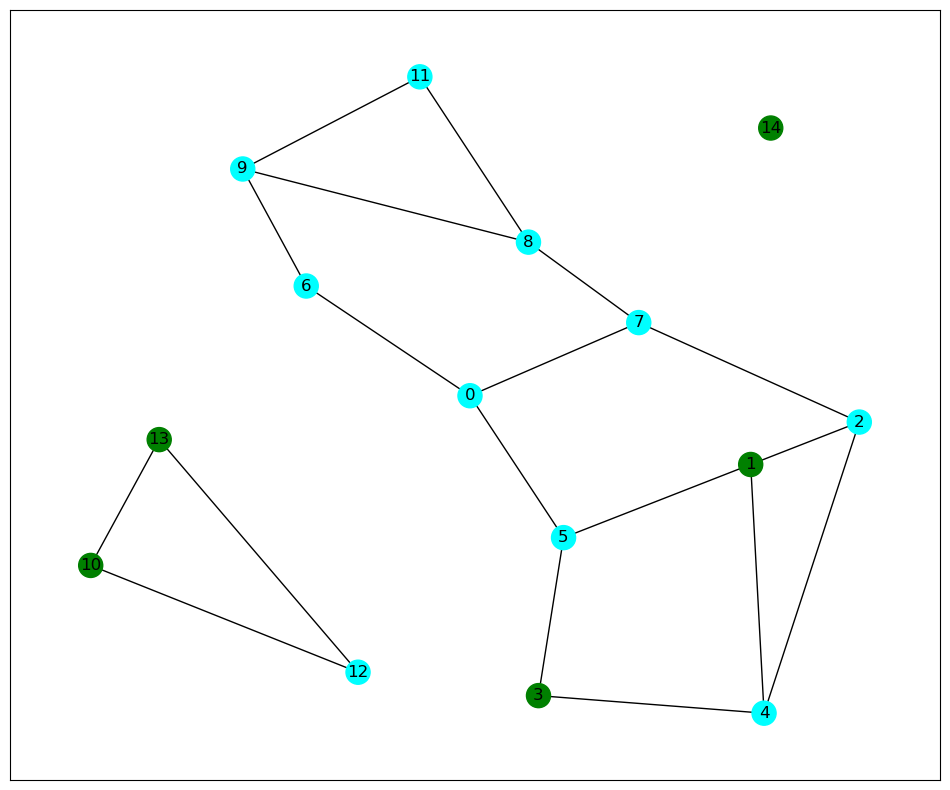

In [10]:
edges_to_remove = []
for i, j in V.edges():

    if delta_ij[i, j].X == 1:
        
        edges_to_remove.append((i, j))
color_map2 = []
for i in V.nodes():
    if u[i].X==1 and V.nodes[i]['S']==1:
        color_map2.append('red')
    elif u[i].X==0 and V.nodes[i]['S']==1:
        color_map2.append('green')
    else:
        color_map2.append('cyan')

for edge in edges_to_remove:
    V.remove_edge(*edge)
#nx.draw(G, with_labels=True, , node_size=800, font_color='white', font_weight='bold')
plt.figure(figsize=(12, 10))
nx.draw_networkx(V, with_labels=True,node_color=color_map2, pos=node_positions)